# Data Exploaration of the titanic data set

In [161]:
#import the relevant libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [162]:
#Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [163]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [164]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Interpretation of the descriptive statistics

- 38,3% of the training set survived
- Age ranges from 0.4 to 80 years. Age has a lot of missing values. Mean and median age are close.
- 50% had no sib or spouse. 75% had 1.0 or less than one sibling or spouse.
- 75% had no parent or child on board
- The mean fare is almost twice as big as median --> outlier
- A lot of missing values in the cabin --> What to do with them?
- only two missing values in the Embarked --> drop them :)
- There were a few big family groups

Captain died

In [165]:
train_df[train_df['Name'].str.contains('Capt')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S


Harriet was the daughter of the captain and she survived

In [166]:
cabin_df = train_df[train_df['Cabin'].notna()]
cabin_df[cabin_df['Cabin'].str.contains('B22')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.0,B22,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S


# Investigation of the correlation of the features with the survival rate

### Some first preparations for analyzing the data

- extract title feature instead of Name
- extract Deck feature instead of cabin

In [167]:
train_df = train_df[['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin']].copy()
train_df.loc[train_df['Name'].str.contains('Mr.'), 'Title'] = 'MR'
train_df.loc[train_df['Name'].str.contains('Mrs.'), 'Title'] = 'MRS'
train_df.loc[train_df['Name'].str.contains('Miss.'), 'Title'] = 'MISS'
train_df.loc[train_df['Name'].str.contains('Master.'), 'Title'] = 'MASTER'
train_df.loc[train_df['Name'].str.contains('Rev.'), 'Title'] = 'REV'

train_df['Deck'] = train_df['Cabin'].str[0]

train_df.drop(['Name', 'Cabin'], axis=1, inplace=True)

### Plotting features against survival rate

In [168]:
def plot_survival_for_class_features(df, feature, bar_width=0.2):
  df = df[df[feature].notna()]
  category_counter = Counter(df[feature].to_list())
  groups = ['Died', 'Survived']

  x = sorted(list(category_counter.keys()))
  bars = []

  for idx in range(len(groups)):
    if (idx == 0):
        bars.append(np.arange(len(x)))
    else:
        bars.append([x_i + bar_width for x_i in bars[idx - 1]])

  category_stats = {}
  for idx, category in enumerate(x):
    cat_df = df[df[feature] == category]
    counter = Counter(cat_df['Survived'].to_list())
    category_stats[category] = counter

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axs = axs.flatten()
  cat_sizes =[max(category_stats[cat][0] + category_stats[cat][1], 1) for cat in x] #avoid division by zero
  for idx, group in enumerate(groups):
    axs[0].bar(bars[idx], [category_stats[cat][idx] for cat in x], label=group, width=bar_width)
    axs[1].bar(bars[idx], [(category_stats[cat][idx] / cat_size) * 100 for cat, cat_size in zip(x, cat_sizes)], width=bar_width)

  padding = 0 if len(bars) % 2 != 0 else bar_width/2
  middle_bar = bars[len(bars) // 2] if len(bars) % 2 != 0 else bars[len(bars) // 2 - 1]
  fig.suptitle(f"Survival rate vs. {feature}")
  axs[0].legend()
  axs[0].set_ylabel('# of passenger')
  axs[1].set_ylabel('% of all category')
  axs[0].set_xticks(ticks=[x_i + padding for x_i in middle_bar], labels=x)
  axs[1].set_xticks(ticks=[x_i + padding for x_i in middle_bar], labels=x)
  plt.show()

### 1. Deck

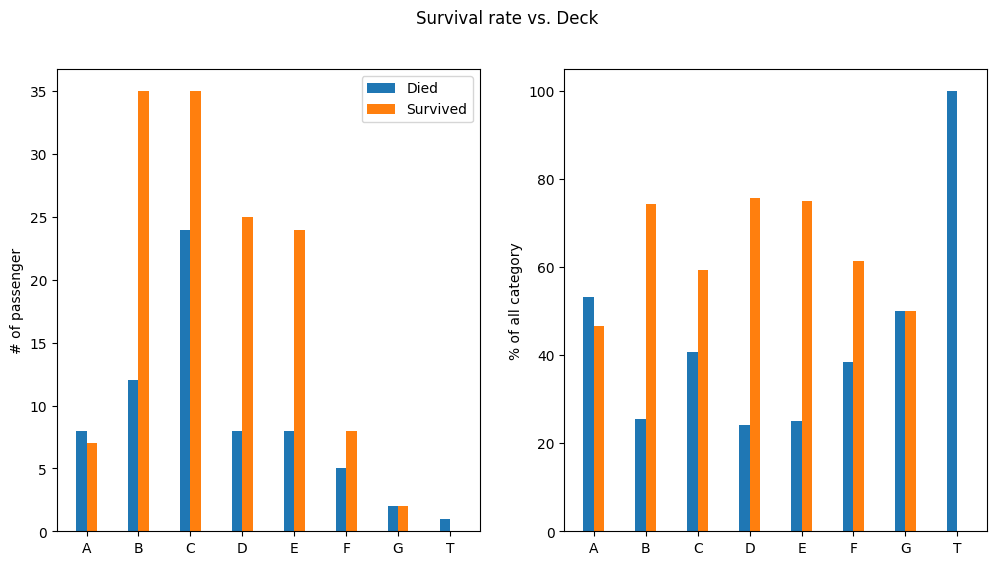

,Fare
Deck,
A,39.623887
B,113.505764
C,100.151341
D,57.244576
E,46.026694
F,18.696792
G,13.581250
T,35.500000


In [169]:
plot_survival_for_class_features(train_df, 'Deck')
train_df.groupby('Deck')['Fare'].mean()

A, B, and C are the highclass decks --> A should have a way higher fare???

### 2. Sex

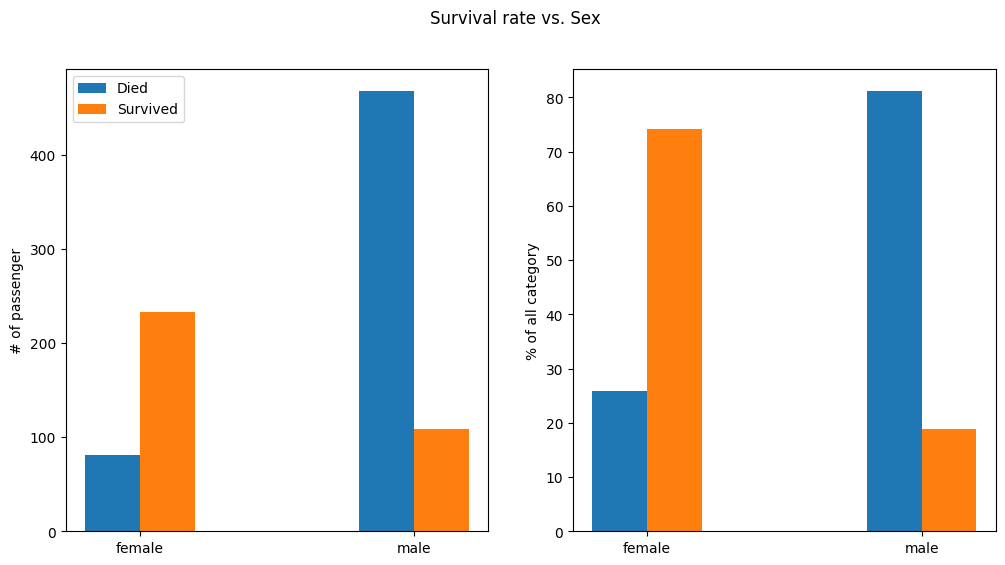

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

In [170]:
plot_survival_for_class_features(train_df, 'Sex')
train_df.groupby(['Sex', 'Survived']).size()

### 3. Parch (Parent or children)

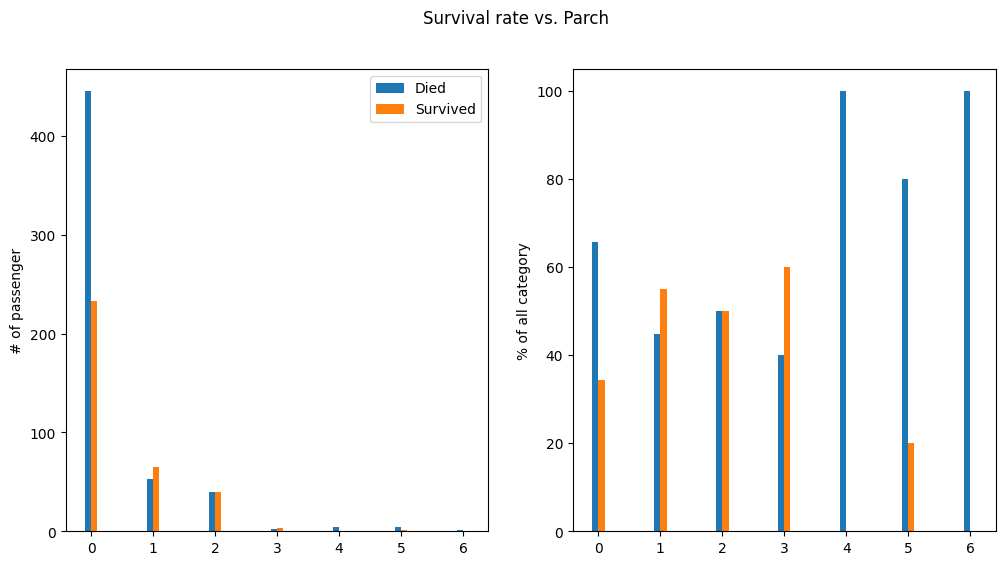

In [171]:
plot_survival_for_class_features(train_df, 'Parch', bar_width=0.1)

### 4. SibSp (Siblings or spouse)

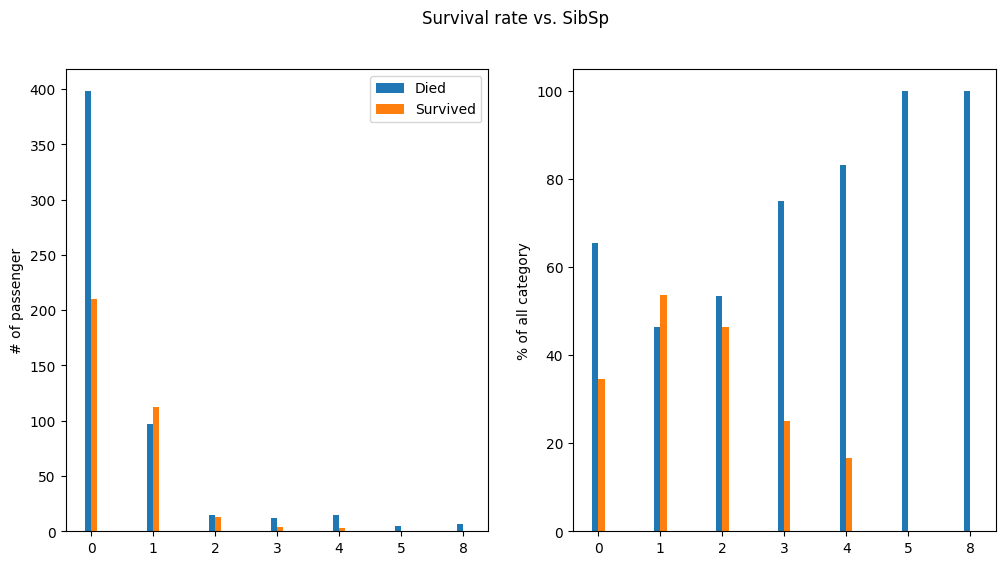

In [172]:
plot_survival_for_class_features(train_df, 'SibSp', bar_width=0.1)

### 5. Pclass (Passenger class)

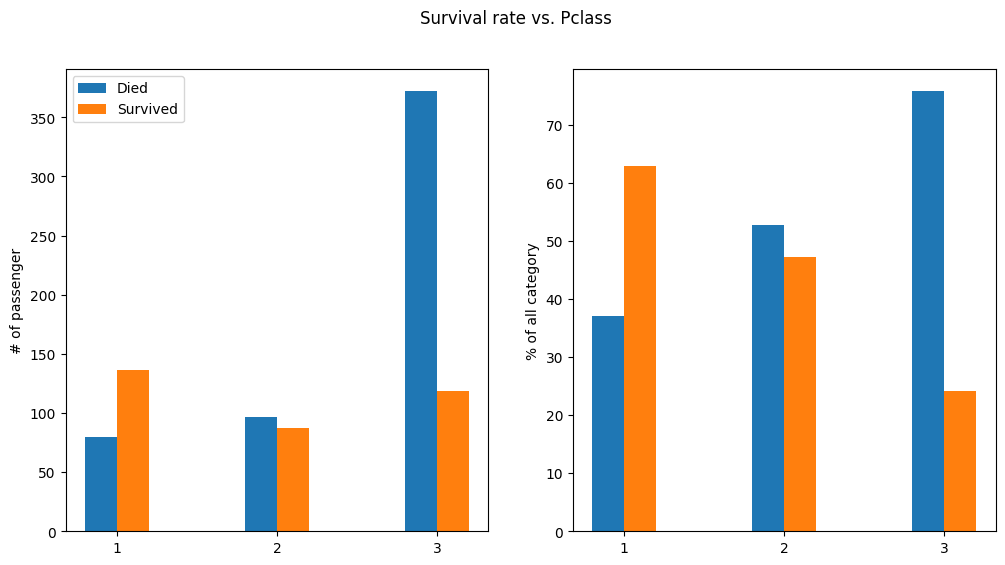

In [173]:
plot_survival_for_class_features(train_df, 'Pclass')

### 6. Embarked

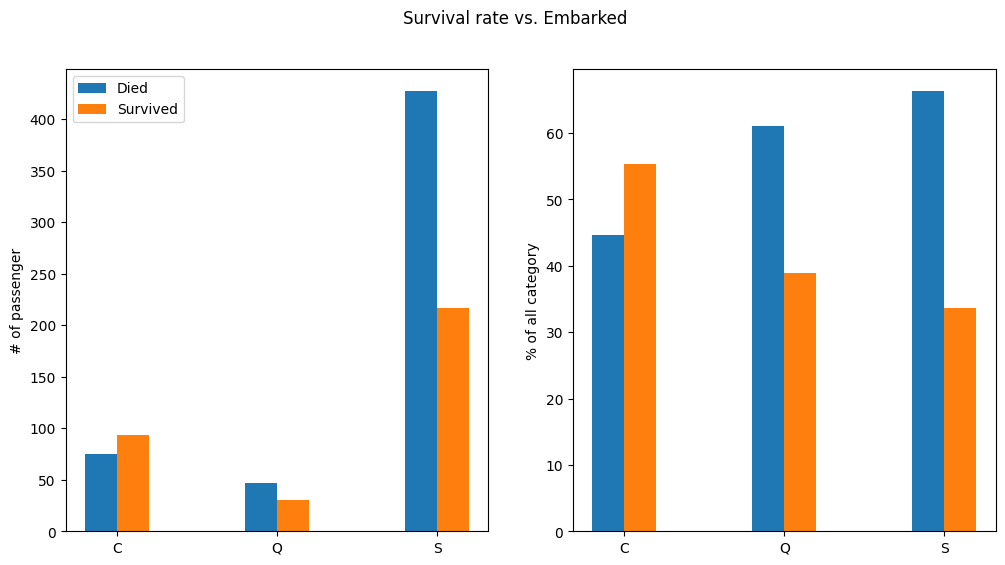

In [174]:
plot_survival_for_class_features(train_df, 'Embarked')

### 7. Title

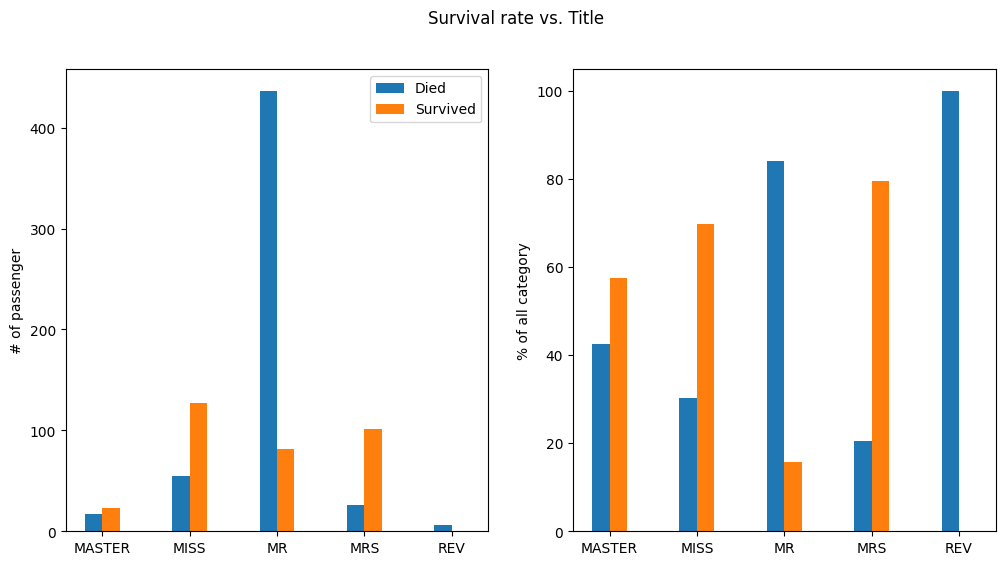

In [175]:
plot_survival_for_class_features(train_df, 'Title')

### 8. Age

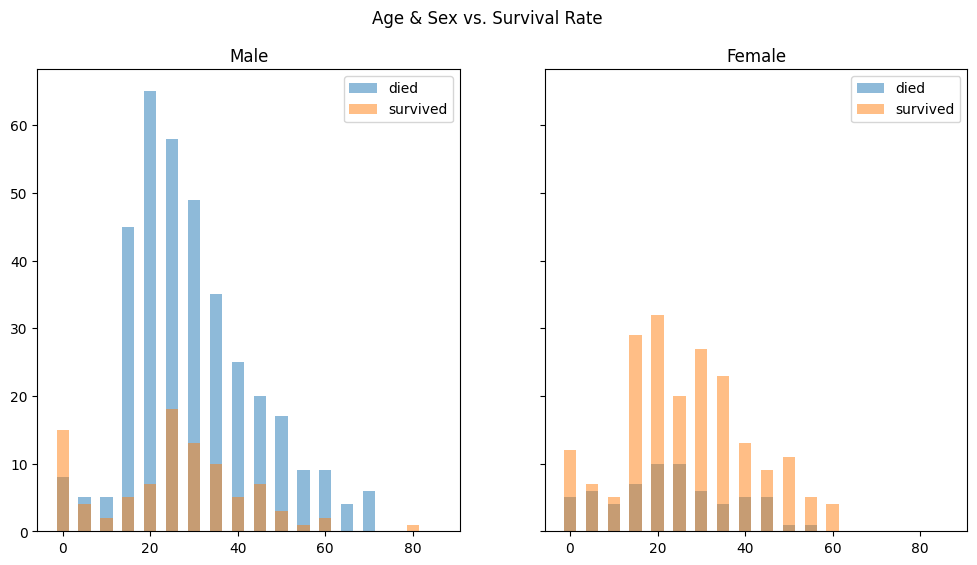

In [176]:
def create_buckets(df, feature, bucket_size=5):
  max = int(train_df[feature].max(axis=0))
  max = max - max % bucket_size + bucket_size

  buckets = {step: [] for step in range(0, max + bucket_size, bucket_size)}

  for age in df['Age']:
    if pd.isna(age):
        continue
    bucket = int(np.floor(age // bucket_size) * bucket_size)
    buckets[bucket].append(age)
  return buckets

male_survived_df = train_df[(train_df['Sex'] == 'male') & (train_df['Survived'] == 1)]
male_died_df = train_df[(train_df['Sex'] == 'male') & (train_df['Survived'] == 0)]
female_survived_df = train_df[(train_df['Sex'] == 'female') & (train_df['Survived'] == 1)]
female_died_df = train_df[(train_df['Sex'] == 'female') & (train_df['Survived'] == 0)]

male_survived_buckets = create_buckets(male_survived_df, 'Age')
male_died_buckets = create_buckets(male_died_df, 'Age')
female_survived_buckets = create_buckets(female_survived_df, 'Age')
female_died_buckets = create_buckets(female_died_df, 'Age')

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))
axes = axes.flatten()

plt.suptitle("Age & Sex vs. Survival Rate")
ages = [age for age in male_died_buckets.keys()]
axes[0].bar(ages, [len(count) for count in male_died_buckets.values()], width=2.8, alpha=0.5, label='died')
axes[0].bar(ages, [len(count) for count in male_survived_buckets.values()], width=2.8, alpha=0.5, label='survived')
axes[0].set_title('Male')
axes[0].legend()

axes[1].bar(ages, [len(count) for count in female_died_buckets.values()], width=2.8, alpha=0.5, label='died')
axes[1].bar(ages, [len(count) for count in female_survived_buckets.values()], width=2.8, alpha=0.5, label='survived')
axes[1].set_title('Female')
axes[1].legend()

plt.show()

### 9. Fare

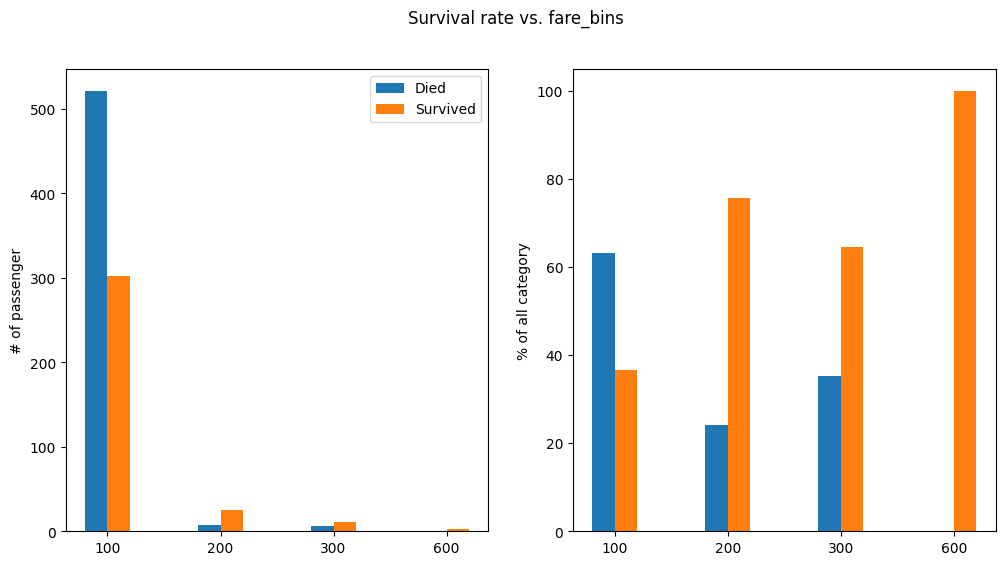

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,0,3,male,22.0,1,0,7.2500,S,MR,NaN
1,1,1,female,38.0,1,0,71.2833,C,MRS,C
2,1,3,female,26.0,0,0,7.9250,S,MISS,NaN
3,1,1,female,35.0,1,0,53.1000,S,MRS,C
4,0,3,male,35.0,0,0,8.0500,S,MR,NaN
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,REV,NaN
887,1,1,female,19.0,0,0,30.0000,S,MISS,B
888,0,3,female,NaN,1,2,23.4500,S,MISS,NaN
889,1,1,male,26.0,0,0,30.0000,C,MR,C


In [177]:
train_df['fare_bins'] = pd.cut(train_df['Fare'], bins=[x for x in range(0, 700, 100)])
train_df['fare_bins'] = train_df['fare_bins'].apply(lambda x: x.right)
plot_survival_for_class_features(train_df, 'fare_bins')
train_df.drop(columns=['fare_bins'])


In [178]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,fare_bins
0,0,3,male,22.0,1,0,7.2500,S,MR,NaN,100
1,1,1,female,38.0,1,0,71.2833,C,MRS,C,100
2,1,3,female,26.0,0,0,7.9250,S,MISS,NaN,100
3,1,1,female,35.0,1,0,53.1000,S,MRS,C,100
4,0,3,male,35.0,0,0,8.0500,S,MR,NaN,100


In [179]:
train_df.groupby(['Sex', 'Pclass'])[['Age', 'SibSp', 'Parch', 'Fare', 'fare_bins']].max()

Age  SibSp  Parch      Fare fare_bins
Sex    Pclass                                        
female 1       63.0      3      2  512.3292       600
       2       57.0      3      3   65.0000       100
       3       63.0      8      6   69.5500       100
male   1       80.0      3      4  512.3292       600
       2       70.0      2      2   73.5000       100
       3       74.0      8      5   69.5500       100

wimen paid on average more in every class than men!!! --> Discrimination

In [180]:
train_df.groupby(['Survived'])[['Age', 'SibSp', 'Parch', 'Fare']].mean()

,Age,SibSp,Parch,Fare
Survived,,,,
0,30.626179,0.553734,0.329690,22.117887
1,28.343690,0.473684,0.464912,48.395408


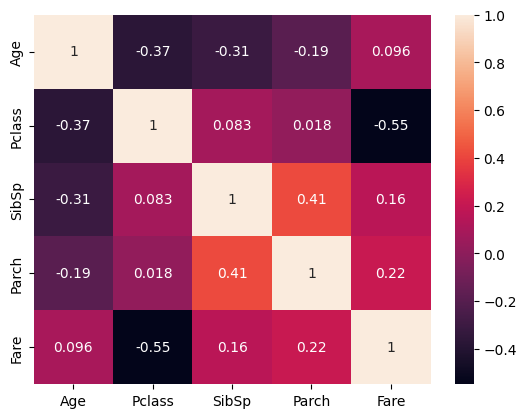

In [181]:
numerics_df = train_df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]

ax = sns.heatmap(numerics_df.corr(), annot=True)



### Interpretation:
- moderate positive correlation between SibSp and Parch. Higher probabilty of familiy travelling
- moderate negative correlation between Pclass and age --> Older people more likely to travel in hiher class
- strong negative between higher pclass and fare --> higher classes are more expensive ...
- slight negative correlation between SipSp and Age. Young travellers tend to have more siblings or spouses...

# Data preprocessing
- drop outliers in fare
- impute values
- combine SibSp and Parch
- Z score normalize the numeric features
- one hot encoding for categorized features

In [182]:
def z_score_normalization(df, features):
    for feature in features:
        mean = df[feature].mean()
        std = df[feature].std()

        df[feature] = (df[feature] - mean)/std

### 1. Impute the missing ages with the mean

In [185]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    int64   
 2   Sex        891 non-null    object  
 3   Age        891 non-null    float64 
 4   SibSp      891 non-null    int64   
 5   Parch      891 non-null    int64   
 6   Fare       891 non-null    float64 
 7   Embarked   889 non-null    object  
 8   Title      873 non-null    object  
 9   Deck       204 non-null    object  
 10  fare_bins  876 non-null    category
dtypes: category(1), float64(2), int64(4), object(4)
memory usage: 70.8+ KB


In [186]:
#Replace outlier fare the outlier
pclass_1_fare_mean = train_df[train_df['Pclass'] == 1]['Fare'].mean()
train_df.loc[train_df['Fare'] > 300, 'Fare'] = pclass_1_fare_mean


### Combine SibSP and Parch

In [187]:
#adding 1 is not relevant for traing but just for correctness
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1

### Normalizing

In [188]:
z_score_normalization(train_df, ['Pclass', 'Age', 'Family_Size', 'Fare'])
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size
count,891.000000,8.910000e+02,8.910000e+02,891.000000,891.000000,8.910000e+02,8.910000e+02
mean,0.383838,-4.386066e-17,2.153160e-16,0.523008,0.381594,1.395567e-17,-8.772133e-17
std,0.486592,1.000000e+00,1.000000e+00,1.102743,0.806057,1.000000e+00,1.000000e+00
min,0.000000,-1.565228e+00,-2.251891e+00,0.000000,0.000000,-7.462286e-01,-5.606599e-01
25%,0.000000,-3.691575e-01,-5.921480e-01,0.000000,0.000000,-5.543405e-01,-5.606599e-01
50%,0.000000,8.269128e-01,0.000000e+00,0.000000,0.000000,-3.956029e-01,-5.606599e-01
75%,1.000000,8.269128e-01,4.076970e-01,1.000000,0.000000,5.760163e-03,5.912667e-02
max,1.000000,8.269128e-01,3.868699e+00,8.000000,6.000000,5.633547e+00,5.637206e+00


# Model Training

## Split the training data

In [189]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def split_data(train_df, numerical_features, categorical_features, target, test_size=0.2):
  '''
    Splitting before scaling is crucial to prevent data leakage!
    Only call fit on the the training set to prevent data leakage!
    Otherwise false sense of accuracy, because through fitting we
    already learn somethong about the test set.
  '''
  X = train_df[numerical_features + categorical_features]
  y = train_df[target].to_numpy()

  X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

  scaler = StandardScaler()
  X_train_num = scaler.fit_transform(X_train_df[numerical_features])
  X_test_num = scaler.transform(X_test_df[numerical_features])

  encoder = OneHotEncoder(sparse_output=False, drop='first')
  X_train_cat = encoder.fit_transform(X_train_df[categorical_features])
  X_test_cat = encoder.transform(X_test_df[categorical_features])

  X_train = np.hstack((X_train_num, X_train_cat))
  X_test = np.hstack((X_test_num, X_test_cat))

  return X_train, X_test, y_train, y_test

## Evaluation Method
- accuracy
- confusion matrix

In [201]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_train, X_test, y_train, y_test, labels=['Died', 'Survived']):
  y_pred_test = model.predict(X_test)
  y_pred_train = model.predict(X_train)
  if (type(y_pred_train) is torch.Tensor):
    y_pred_test = np.reshape(y_pred_test.numpy(), newshape=len(y_test))
    y_pred_train = np.reshape(y_pred_train.numpy(), newshape=len(y_train))
  train_accuracy = (sum(y_pred_train == y_train) / len(y_train)) * 100
  test_accuracy = (sum(y_pred_test == y_test) / len(y_test)) * 100
  print(f"Train accuracy: {train_accuracy:.2f}, test accuracy: {test_accuracy:.2f}")
  cm = confusion_matrix(y_test, y_pred_test)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()



## Logistic Regression
### Hyperparamters:
- C: Inverse of the Regularization constant --> Higher C, fitting the training data more closely (overfitting)
- class_weight: handle imbalances classes
- penalty: Type of regulaization used
- solver: optimization algorithm to minimize the cost

Train accuracy: 79.92, test accuracy: 81.01


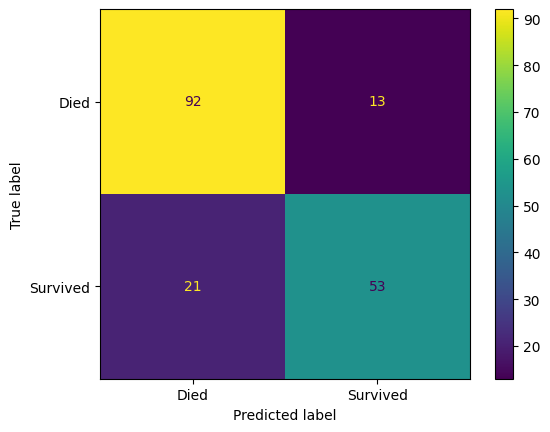

In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # only supports l1 + l2
    'class_weight': [None, 'balanced']
}

X_train, X_test, y_train, y_test = split_data(
    train_df,
    numerical_features=['Pclass', 'Age', 'Family_Size', 'Fare'],
    categorical_features = ['Sex'],
    target = 'Survived')

# grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)
# grid.fit(X_train, y_train)

# print(f"Best params: {grid.best_params_}")
# print(f"Test accuracy: {grid.score(X_test, y_test):.2f}")

lr_clf = LogisticRegression(max_iter=100, C=10, class_weight=None, penalty='l2', solver='liblinear')
lr_clf.fit(X_train, y_train)

evaluate_model(lr_clf, X_train, X_test, y_train, y_test)

## Naive Bayes

In [192]:
#TBD

## Decision Tree

Train accuracy: 83.43, test accuracy: 79.89


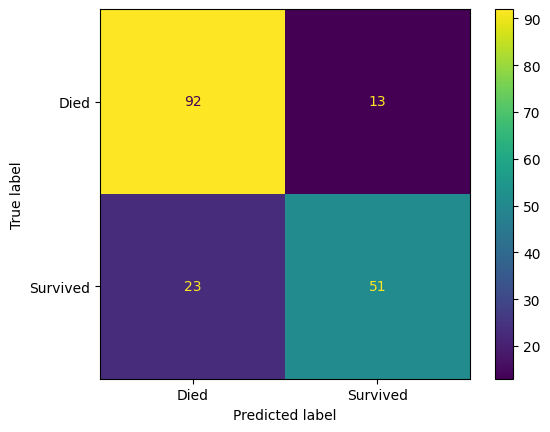

In [207]:
from sklearn import tree

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

X_train, X_test, y_train, y_test = split_data(
    train_df,
    numerical_features=['Pclass', 'Age', 'Family_Size', 'Fare'],
    categorical_features = ['Sex'],
    target = 'Survived')

# grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid)
# grid.fit(X_train, y_train)
# print(f"Best params: {grid.best_params_}")
# print(f"Test accuracy: {grid.score(X_test, y_test):.2f}")

tree_clf = tree.DecisionTreeClassifier(max_depth=3, criterion='gini',  min_samples_leaf=2, min_samples_split=2)
tree_clf.fit(X_train, y_train)

# Plot the decision tree
#plt.figure(figsize=(12,8))
#tree.plot_tree(tree_clf, filled=True, feature_names = ['Pclass', 'Age', 'Family_Size', 'Fare', 'Sex_male'], class_names=['Died', 'Survived'])
#plt.show()

evaluate_model(tree_clf, X_train, X_test, y_train, y_test)

## Random Forest (Tree ensamle)

Train accuracy: 86.66, test accuracy: 79.89


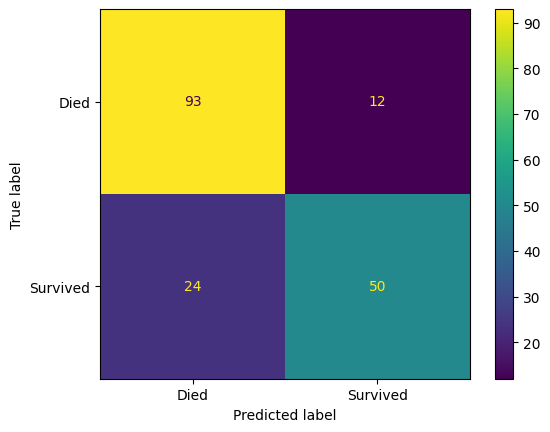

In [208]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

X_train, X_test, y_train, y_test = split_data(
    train_df,
    numerical_features=['Pclass', 'Age', 'Family_Size', 'Fare'],
    categorical_features = ['Sex'],
    target = 'Survived')

# grid = GridSearchCV(RandomForestClassifier(), param_grid)
# grid.fit(X_train, y_train)
# print(f"Best params: {grid.best_params_}")
# print(f"Test accuracy: {grid.score(X_test, y_test):.2f}")

forest_clf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=5)
forest_clf.fit(X_train, y_train)

evaluate_model(forest_clf, X_train, X_test, y_train, y_test)


## XGBoost

In [195]:
#TBD

## Support Vecotor Machine

In [196]:
#TBD

## KNN (PCA helpful?)

## Neural Network

In [209]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F


In [198]:
class Data(Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.X.shape[0]

class NeuralNetwork(nn.Module):
  def __init__(self, input_size) -> None:
    super().__init__()
    self.layer1 = nn.Linear(in_features=input_size, out_features=16)
    self.layer2 = nn.Linear(in_features=16, out_features=8)
    self.output = nn.Linear(in_features=8, out_features=1)

  def forward(self, X):
    x = F.relu(self.layer1(X))
    x = F.relu(self.layer2(x))
    return self.output(x)

  def predict(self, X):
    return (torch.sigmoid(self.forward(X)) >= 0.5).float()

  def evaluate(self, test_dataset, loss_fn):
      test_dataloader = DataLoader(test_dataset)
      self.eval()
      correct = 0
      total_loss = 0
      total_samples = 0

      with torch.no_grad():
          for X, y in test_dataloader:
              y = y.reshape(-1, 1).float()
              logits = self.forward(X)
              predict = (torch.sigmoid(logits) > 0.5).float()
              correct += (predict == y).sum().item()
              total_loss += loss_fn(logits, y).item() * len(X)
              total_samples += len(X)

      accuracy = correct / total_samples
      average_loss = total_loss / total_samples
      return accuracy, average_loss


  def fit(self, train_dataset, test_dataset, epochs, loss_fn, optimizer):
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    self.train()
    for epoch in range(epochs):
      train_loss = 0
      test_loss = 0
      for X, y in train_loader:
        y = y.reshape(-1, 1)
        predict = self.forward(X)
        loss = loss_fn(predict, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      test_accuracy, test_loss = self.evaluate(test_dataset, loss_fn)
      train_accuracy, train_loss = self.evaluate(train_dataset, loss_fn)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_accuracies.append(train_accuracy)
      test_accuracies.append(test_accuracy)
      if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train loss: {train_loss}, Test_loss: {test_loss}, Test_accuracy: {test_accuracy}")

    return train_losses, test_losses, train_accuracies, test_accuracies


Epoch 0: Train loss: 0.7168681824977479, Test_loss: 0.7109809441273439, Test_accuracy: 0.4134078212290503
Epoch 10: Train loss: 0.6331671418601208, Test_loss: 0.6319746674772081, Test_accuracy: 0.7430167597765364
Epoch 20: Train loss: 0.5646355181848735, Test_loss: 0.5549319466399081, Test_accuracy: 0.7318435754189944
Epoch 30: Train loss: 0.5092683044377337, Test_loss: 0.4864035627528942, Test_accuracy: 0.8044692737430168
Epoch 40: Train loss: 0.4706340336314078, Test_loss: 0.44444362835844137, Test_accuracy: 0.8212290502793296
Epoch 50: Train loss: 0.4527983297227641, Test_loss: 0.4265714063824222, Test_accuracy: 0.8156424581005587
Epoch 60: Train loss: 0.44388189878356593, Test_loss: 0.42280408644309925, Test_accuracy: 0.8156424581005587
Epoch 70: Train loss: 0.43883383651839547, Test_loss: 0.41918796242615364, Test_accuracy: 0.8268156424581006
Epoch 80: Train loss: 0.4349235730308495, Test_loss: 0.4166458073025309, Test_accuracy: 0.8268156424581006
Epoch 90: Train loss: 0.432536043

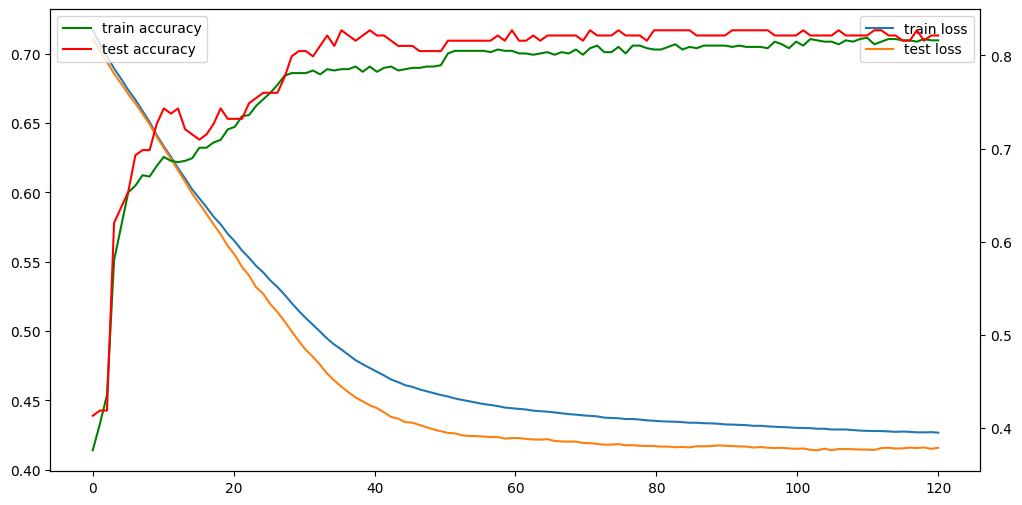

In [212]:
X_train, X_test, y_train, y_test = split_data(
    train_df,
    numerical_features=['Pclass', 'Age', 'Family_Size', 'Fare'],
    categorical_features = ['Sex'],
    target = 'Survived')

train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)

epochs = 120

model = NeuralNetwork(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.015)
train_losses, test_losses, train_accuracies, test_accuracies = model.fit(train_dataset, test_dataset, epochs, nn.BCEWithLogitsLoss(), optimizer)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
x = np.linspace(0, epochs, epochs)
ax1.plot(x, train_losses, label='train loss')
ax1.plot(x, test_losses, label='test loss')
ax2.plot(x, train_accuracies, label='train accuracy', color='g')
ax2.plot(x, test_accuracies, label='test accuracy', color='r')
ax2.legend()
ax1.legend()
plt.show()

Train accuracy: 81.60, test accuracy: 82.12


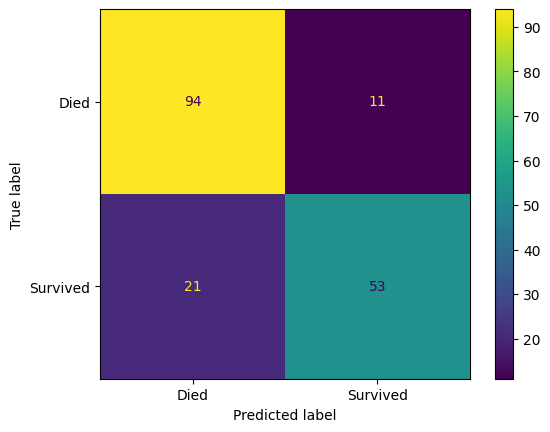

In [213]:
evaluate_model(model, train_dataset.X, test_dataset.X, train_dataset.y, test_dataset.y)

# Learn
- Cross validation
- Regularization